# Preliminary Exploratory Data Analysis

### 1. Setup and Data Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cal_df = pd.read_csv('data/raw/calendar2024.csv')
lis_df = pd.read_csv('data/raw/listings2024.csv') 
rev_df = pd.read_csv('data/raw/reviews2024.csv')
print('cal:',cal_df.shape)
print('rev:',rev_df.shape)
print('lis:',lis_df.shape)

cal: (7631731, 7)
rev: (366636, 6)
lis: (20909, 75)


### 2. Initial Data Preview

In [3]:
lis_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,31094,https://www.airbnb.com/rooms/31094,20240629155650,2024-06-30,previous scrape,"Beautiful, spacious, central, renovated Penthouse","Welcome to our home, we hope you will enjoy Wo...","What else is nearby?<br />To be honest, We thi...",https://a0.muscache.com/pictures/miso/Hosting-...,129976,...,4.82,4.80,4.53,NaN,f,1,1,0,0,0.11
1,262961,https://www.airbnb.com/rooms/262961,20240629155650,2024-06-30,city scrape,192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD,If you are looking for a large apartment in ce...,TIME OUT - The world’s coolest neighbourhoods ...,https://a0.muscache.com/pictures/261aa506-7b13...,1379904,...,4.94,4.89,4.53,NaN,f,1,1,0,0,0.24
2,263036,https://www.airbnb.com/rooms/263036,20240629155650,2024-06-30,city scrape,Bright flat in central location,NaN,NaN,https://a0.muscache.com/pictures/17770169/f1fb...,1232471,...,4.86,4.81,4.67,NaN,f,1,1,0,0,0.14
3,32379,https://www.airbnb.com/rooms/32379,20240629155650,2024-06-30,city scrape,"155 m2 artist flat on Vesterbro, with 2 bathrooms",You enter a narrow entrance and feel the good ...,"Værnedamsvej area is super hip area, we call i...",https://a0.muscache.com/pictures/miso/Hosting-...,140105,...,4.91,4.89,4.71,NaN,f,2,1,1,0,0.49
4,263708,https://www.airbnb.com/rooms/263708,20240629155650,2024-06-30,city scrape,Urban garden on Vesterbro rooftop,NaN,NaN,https://a0.muscache.com/pictures/8ce36f40-ac59...,1383888,...,5.00,4.67,4.00,NaN,f,1,1,0,0,0.02


In [4]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,586421,2024-06-30,f,$250.00,NaN,4.0,31.0
1,586421,2024-07-01,f,$250.00,NaN,4.0,31.0
2,586421,2024-07-02,t,$250.00,NaN,4.0,31.0
3,586421,2024-07-03,f,$250.00,NaN,4.0,31.0
4,586421,2024-07-04,f,$250.00,NaN,4.0,31.0


In [5]:
rev_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,31094,79346,2010-08-16,171607,Ben,"We had a great stay. Conveniently located, qui..."
1,31094,166275,2011-01-05,306860,Makita,It was a very good stay. The appartment was re...
2,31094,1452299,2012-06-10,1321058,Pierre,Really enjoyed my time at Ebbe's place. It is...
3,31094,6766430,2013-08-24,2182771,Sussie,"The apartment was very well located, 10-15 min..."
4,31094,6827217,2013-08-26,8025926,Wil,"This is a great flat, very clean with everythi..."


### 3. Data Structure Analysis

In [6]:
def explore_dataset(df, name):
    print(f"\n{'='*50}")
    print(f"Dataset: {name}")
    print(f"{'='*50}")
    
    print("\n1. Basic Information:")
    print(f"Shape: {df.shape}")
    
    print("\n2. Data Types:")
    print(df.dtypes)

    print("\n3. Summary Statistics:")
    print(df.describe())
    
    print("\n4. Unique Values:")
    for col in df.columns:
        n_unique = df[col].nunique()
        if n_unique < 3:
            unique_values = df[col].unique()
            print(f"{col}: {n_unique} unique values")
            print(f"Values: {unique_values}\n")

    print("\n5. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_info[missing_info['Missing Values'] > 0])
    
    return missing_info

In [7]:
listings_missing = explore_dataset(lis_df, 'Listings')


Dataset: Listings

1. Basic Information:
Shape: (20909, 75)

2. Data Types:
id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

3. Summary Statistics:
                 id     scrape_id       host_id  host_listings_count  \
count  2.090900e+04  2.090900e+04  2.090900e+04         20908.000000   
mean   5.137813e+17  2.024063e+13  1.442690e+08             5.942606   
std    4.737075e+17  0.000000e+00  1.6872

In [8]:
calendar_missing = explore_dataset(cal_df, 'Calendar')


Dataset: Calendar

1. Basic Information:
Shape: (7631731, 7)

2. Data Types:
listing_id          int64
date               object
available          object
price              object
adjusted_price    float64
minimum_nights    float64
maximum_nights    float64
dtype: object

3. Summary Statistics:
         listing_id  adjusted_price  minimum_nights  maximum_nights
count  7.631731e+06             0.0    7.631730e+06    7.631730e+06
mean   5.137766e+17             NaN    4.539618e+00    4.302526e+02
std    4.736947e+17             NaN    1.556331e+01    4.529310e+02
min    3.109400e+04             NaN    1.000000e+00    1.000000e+00
25%    3.140450e+07             NaN    2.000000e+00    2.100000e+01
50%    6.452861e+17             NaN    3.000000e+00    3.650000e+02
75%    9.441256e+17             NaN    4.000000e+00    1.125000e+03
max    1.189116e+18             NaN    1.111000e+03    1.125000e+03

4. Unique Values:
available: 2 unique values
Values: ['f' 't']

adjusted_price: 0 unique 

In [9]:
reviews_missing = explore_dataset(rev_df, 'Reviews')


Dataset: Reviews

1. Basic Information:
Shape: (366636, 6)

2. Data Types:
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

3. Summary Statistics:
         listing_id            id   reviewer_id
count  3.666360e+05  3.666360e+05  3.666360e+05
mean   1.853057e+17  5.317194e+17  1.407312e+08
std    3.471587e+17  4.560456e+17  1.508212e+08
min    3.109400e+04  6.875400e+04  1.000000e+00
25%    9.618382e+06  4.188948e+08  2.559502e+07
50%    2.712404e+07  6.533970e+17  7.814352e+07
75%    5.268543e+07  9.476268e+17  2.069679e+08
max    1.185298e+18  1.189808e+18  5.858290e+08

4. Unique Values:

5. Missing Values:
          Missing Values  Percentage
comments              17    0.004637


### 4. Missing Values Visualization

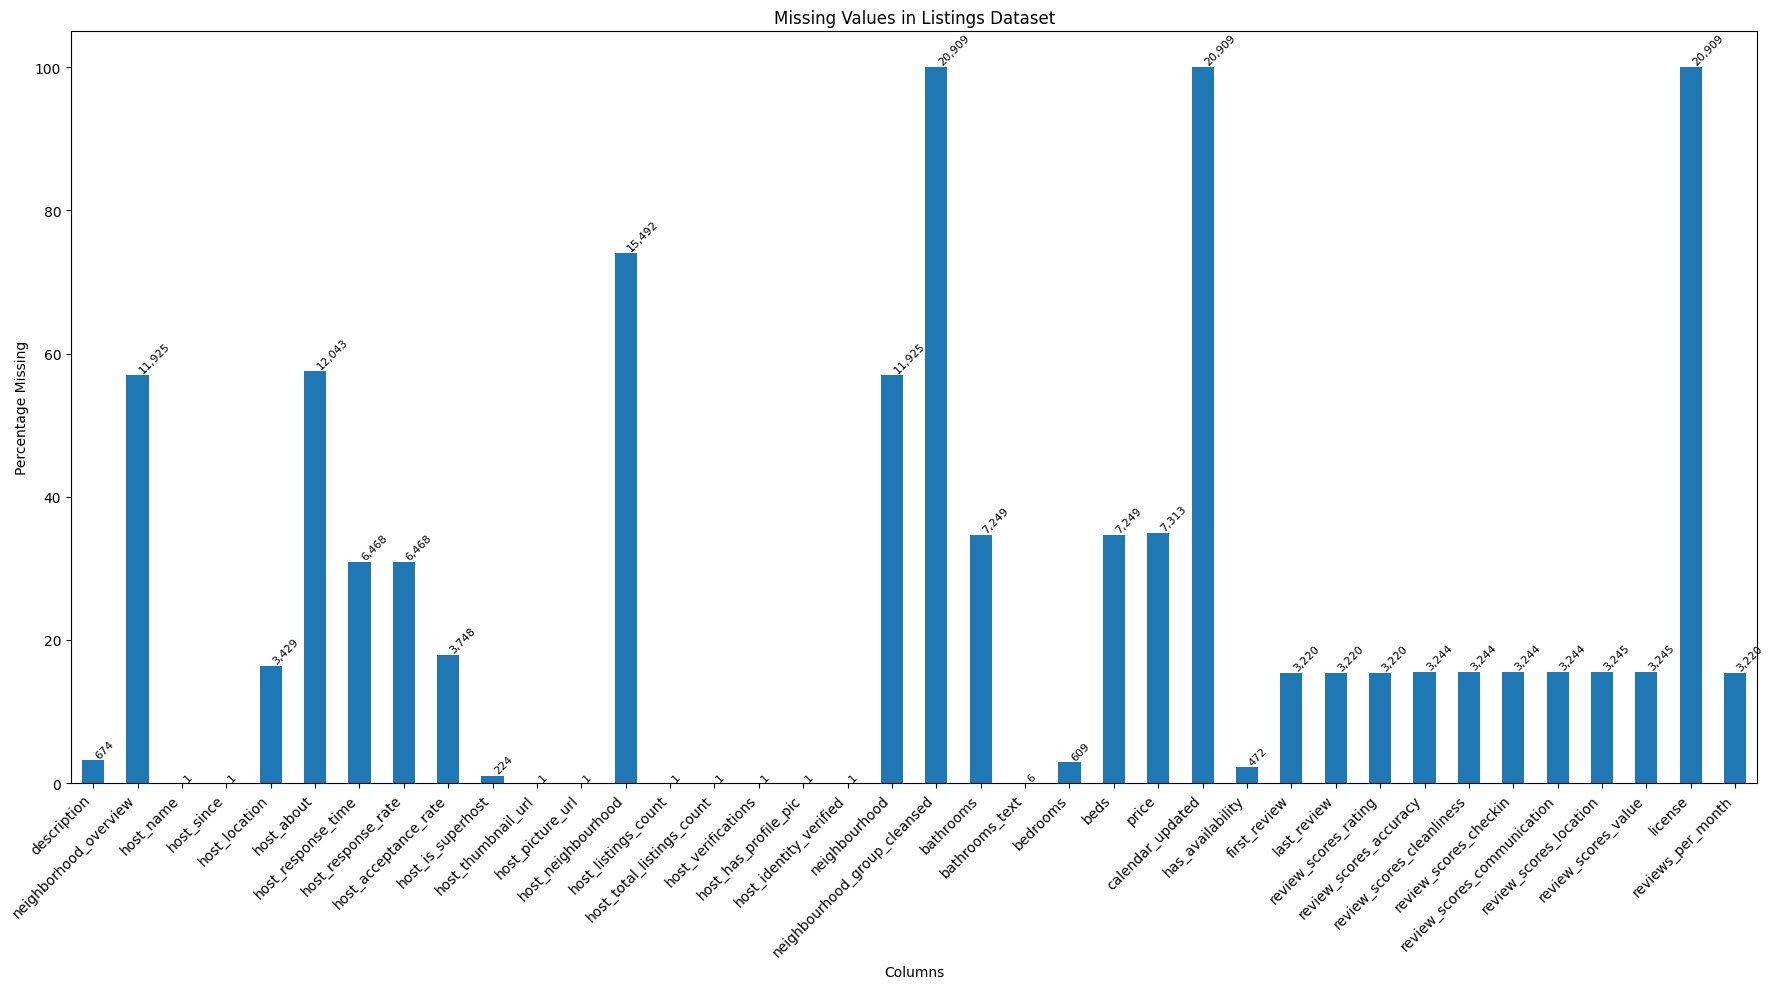

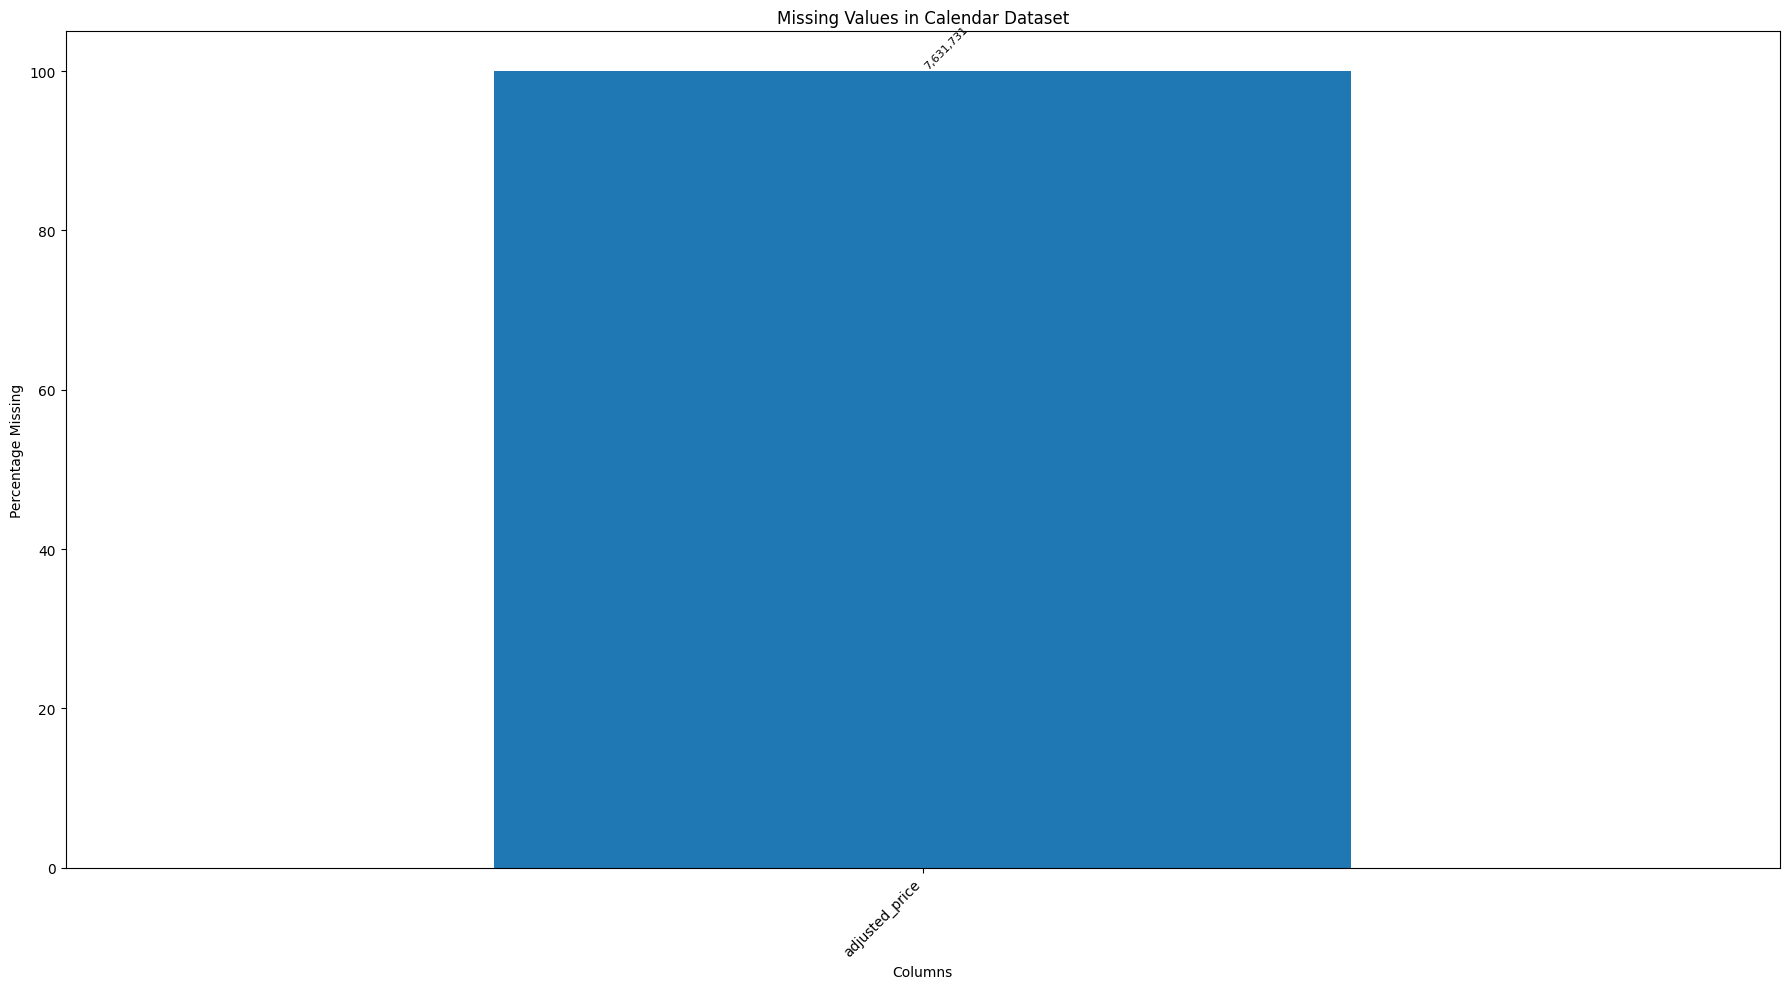

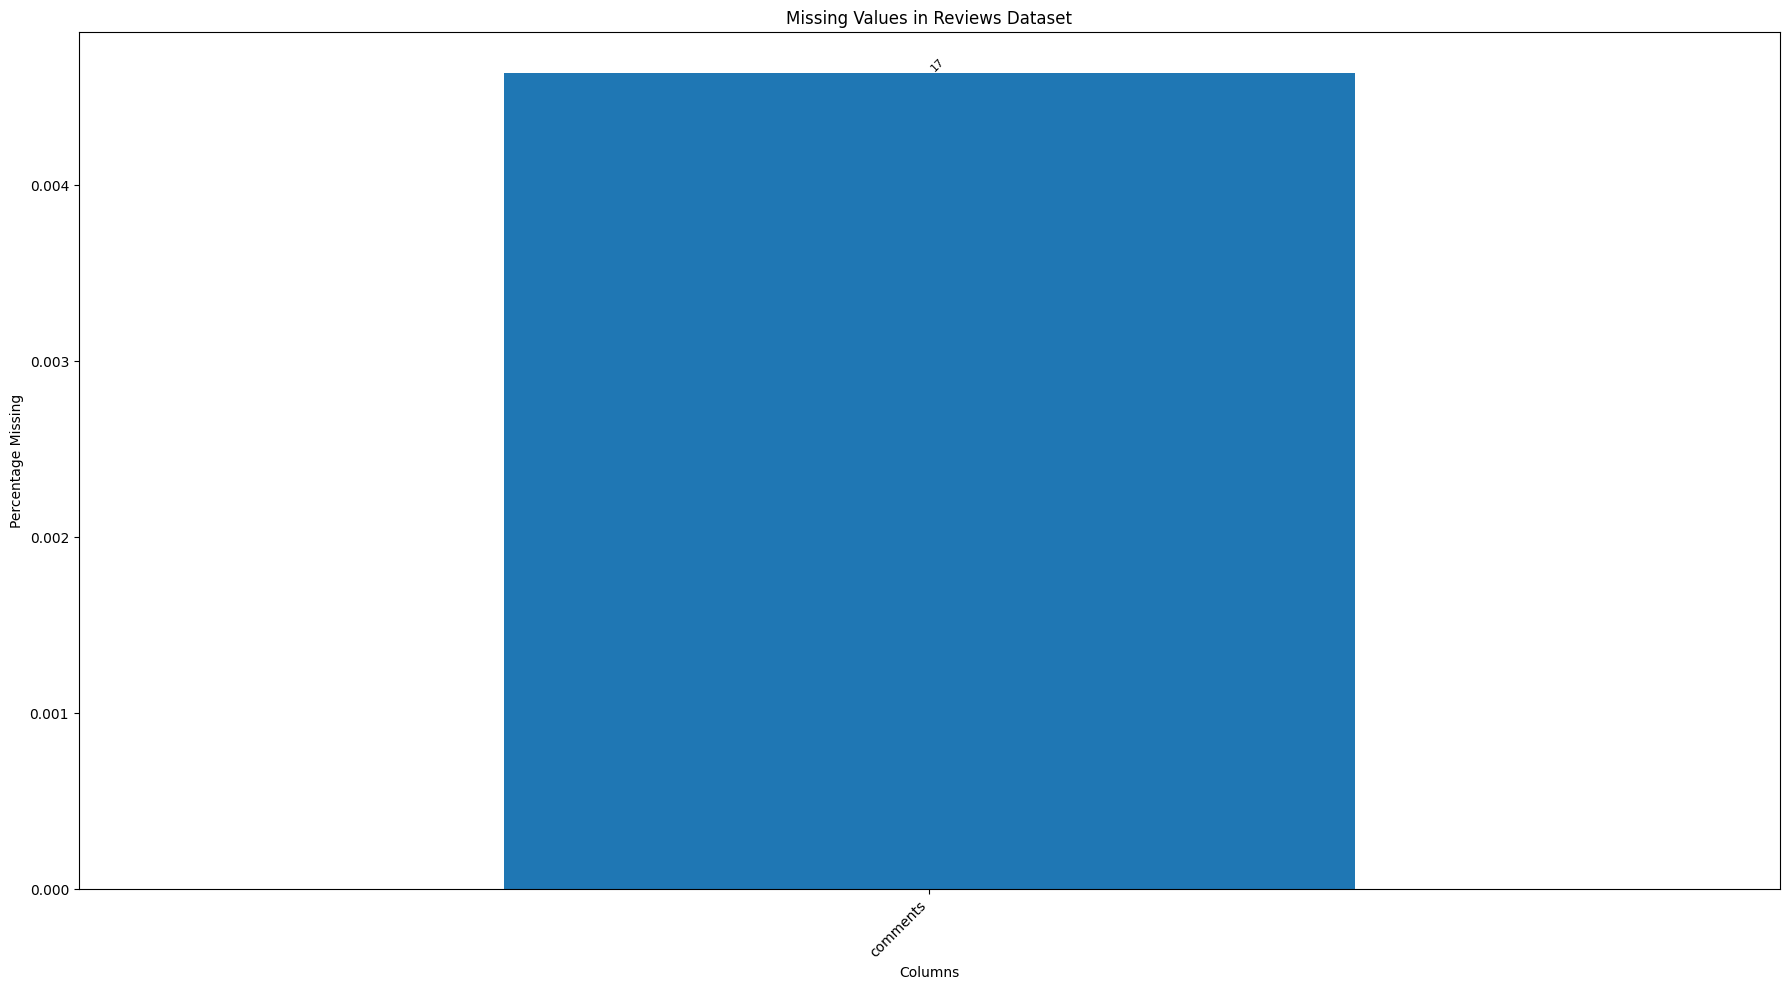

In [10]:
def plot_missing_values(missing_info, title):
    # Filter columns with more than 0.1% missing values
    missing_filtered = missing_info[missing_info['Percentage'] > 0.001]
    
    plt.figure(figsize=(18, 10))
    ax = missing_filtered['Percentage'].plot(kind='bar')
    plt.title(f'Missing Values in {title} Dataset')
    plt.xlabel('Columns')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=45, ha='right')
    
    
    # Add total missing values labels on top of each bar, rotated 45 degrees
    for i, v in enumerate(missing_filtered['Missing Values']):
        ax.text(i, missing_filtered['Percentage'].iloc[i], f'{int(v):,}', 
                ha='left', va='bottom', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot missing values for each dataset
plot_missing_values(listings_missing, 'Listings')
plot_missing_values(calendar_missing, 'Calendar')
plot_missing_values(reviews_missing, 'Reviews')

### 5. Data Quality Assessment

In [11]:
def identify_data_quality_issues(df, name):
    print(f"\n{'='*50}")
    print(f"Data Quality Report for {name}")
    print(f"{'='*50}")
    
    # 1. Check for duplicates
    n_duplicates = df.duplicated().sum()
    if n_duplicates > 0:
        print(f"\nDuplicate rows: {n_duplicates}")
    
    # 2. Check for unexpected values
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    has_unexpected = False
    for col in numeric_cols:
        n_zeros = (df[col] == 0).sum()
        n_negative = (df[col] < 0).sum()
        if n_zeros > 0 or n_negative > 0:
            if not has_unexpected:
                print("\nColumns with unexpected values:")
                has_unexpected = True
            print(f"\n{col}:")
            if n_zeros > 0:
                print(f"- Zeros: {n_zeros} ({(n_zeros/len(df))*100:.2f}%)")
            if n_negative > 0:
                print(f"- Negative values: {n_negative} ({(n_negative/len(df))*100:.2f}%)")
    
    # 3. Check string columns for data inconsistencies
    string_cols = df.select_dtypes(include=['object']).columns
    has_inconsistencies = False
    for col in string_cols:
        n_empty = (df[col] == '').sum()
        n_whitespace = df[col].str.isspace().sum() if df[col].dtype == 'object' else 0
        if n_empty > 0 or n_whitespace > 0:
            if not has_inconsistencies:
                print("\nColumns with inconsistencies:")
                has_inconsistencies = True
            print(f"\n{col}:")
            if n_empty > 0:
                print(f"- Empty strings: {n_empty}")
            if n_whitespace > 0:
                print(f"- Whitespace only: {n_whitespace}")
    
    # 4. Check for extreme values in numeric columns
    has_outliers = False
    for col in numeric_cols:
        mean = df[col].mean()
        std = df[col].std()
        outliers = df[col][abs(df[col] - mean) > 4*std]
        if len(outliers) > 0:
            if not has_outliers:
                print("\nColumns with outliers (beyond 3 std devs):")
                has_outliers = True
            print(f"\n{col}:")
            print(f"- Number of outliers: {len(outliers)}")
            print(f"- Min outlier: {outliers.min()}")
            print(f"- Max outlier: {outliers.max()}")

In [12]:
# Check Listings dataset
identify_data_quality_issues(lis_df, 'Listings')


Data Quality Report for Listings

Columns with unexpected values:

bathrooms:
- Zeros: 38 (0.18%)

bedrooms:
- Zeros: 164 (0.78%)

beds:
- Zeros: 1969 (9.42%)

availability_30:
- Zeros: 8689 (41.56%)

availability_60:
- Zeros: 7486 (35.80%)

availability_90:
- Zeros: 6990 (33.43%)

availability_365:
- Zeros: 5920 (28.31%)

number_of_reviews:
- Zeros: 3220 (15.40%)

number_of_reviews_ltm:
- Zeros: 6815 (32.59%)

number_of_reviews_l30d:
- Zeros: 14768 (70.63%)

calculated_host_listings_count_entire_homes:
- Zeros: 1407 (6.73%)

calculated_host_listings_count_private_rooms:
- Zeros: 18472 (88.34%)

calculated_host_listings_count_shared_rooms:
- Zeros: 20862 (99.78%)

Columns with inconsistencies:

host_about:
- Whitespace only: 41

Columns with outliers (beyond 3 std devs):

host_listings_count:
- Number of outliers: 397
- Min outlier: 142.0
- Max outlier: 667.0

host_total_listings_count:
- Number of outliers: 279
- Min outlier: 659.0
- Max outlier: 1972.0

accommodates:
- Number of out

In [13]:
# Check Calendar dataset
identify_data_quality_issues(cal_df, 'Calendar')

# Additional calendar-specific checks
print("\nChecking calendar date patterns:")
cal_df['date'] = pd.to_datetime(cal_df['date'])
print(f"Date range: {cal_df['date'].min()} to {cal_df['date'].max()}")
print(f"Missing dates: {cal_df['date'].isnull().sum()}")
print(f"Days between min and max date: {(cal_df['date'].max() - cal_df['date'].min()).days}")


Data Quality Report for Calendar

Columns with outliers (beyond 3 std devs):

minimum_nights:
- Number of outliers: 35577
- Min outlier: 70.0
- Max outlier: 1111.0

Checking calendar date patterns:
Date range: 2024-06-29 00:00:00 to 2025-06-29 00:00:00
Missing dates: 0
Days between min and max date: 365


In [14]:
# Check Reviews dataset
identify_data_quality_issues(rev_df, 'Reviews')


Data Quality Report for Reviews


### 6. Data Format Analysis

In [15]:
def check_data_formats(df):
    """Check for inconsistent formats within columns"""
    for col in df.columns:
        # Get sample of unique values
        unique_samples = df[col].dropna().unique()[:2]
        print(f"\n{col}:")
        for sample in unique_samples:
            print(f"Value: {sample}, Type: {type(sample)}")


In [16]:
check_data_formats(lis_df)


id:
Value: 31094, Type: <class 'numpy.int64'>
Value: 262961, Type: <class 'numpy.int64'>

listing_url:
Value: https://www.airbnb.com/rooms/31094, Type: <class 'str'>
Value: https://www.airbnb.com/rooms/262961, Type: <class 'str'>

scrape_id:
Value: 20240629155650, Type: <class 'numpy.int64'>

last_scraped:
Value: 2024-06-30, Type: <class 'str'>
Value: 2024-06-29, Type: <class 'str'>

source:
Value: previous scrape, Type: <class 'str'>
Value: city scrape, Type: <class 'str'>

name:
Value: Beautiful, spacious, central, renovated Penthouse, Type: <class 'str'>
Value: 192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD, Type: <class 'str'>

description:
Value: Welcome to our home, we hope you will enjoy Wonderful Copenhagen!<br /><br />Our penthouse apartment is very spacious with 164 m2 incl. a private rooftop terrasse where you can relax or grill. Despite the location in central Copenhagen, the street is very quiet and the neighbors are never heard.<br /><br />Most attractions are within wa

In [17]:
check_data_formats(cal_df)


listing_id:
Value: 586421, Type: <class 'numpy.int64'>
Value: 31094, Type: <class 'numpy.int64'>

date:
Value: 2024-06-30 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Value: 2024-07-01 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

available:
Value: f, Type: <class 'str'>
Value: t, Type: <class 'str'>

price:
Value: $250.00, Type: <class 'str'>
Value: $2,299.00, Type: <class 'str'>

adjusted_price:

minimum_nights:
Value: 4.0, Type: <class 'numpy.float64'>
Value: 3.0, Type: <class 'numpy.float64'>

maximum_nights:
Value: 31.0, Type: <class 'numpy.float64'>
Value: 10.0, Type: <class 'numpy.float64'>


In [18]:
check_data_formats(rev_df)


listing_id:
Value: 31094, Type: <class 'numpy.int64'>
Value: 32379, Type: <class 'numpy.int64'>

id:
Value: 79346, Type: <class 'numpy.int64'>
Value: 166275, Type: <class 'numpy.int64'>

date:
Value: 2010-08-16, Type: <class 'str'>
Value: 2011-01-05, Type: <class 'str'>

reviewer_id:
Value: 171607, Type: <class 'numpy.int64'>
Value: 306860, Type: <class 'numpy.int64'>

reviewer_name:
Value: Ben, Type: <class 'str'>
Value: Makita, Type: <class 'str'>

comments:
Value: We had a great stay. Conveniently located, quiet and clean flat. , Type: <class 'str'>
Value: It was a very good stay. The appartment was really cosy, well located and very well equiped..., Type: <class 'str'>


### 7. Special Characters Examination

In [19]:
def check_special_characters(df):
    """Check for special characters that might need handling"""
    string_cols = df.select_dtypes(include=['object']).columns
    for col in string_cols:
        # Fixed: Properly chain the .any() method
        if df[col].astype(str).str.contains(r'[^a-zA-Z0-9\s\-.,:/+&æøåÆØÅ]').any():
            print(f"\n{col} contains special characters")
            # Show examples of rows containing special characters
            print(df[df[col].astype(str).str.contains(r'[^a-zA-Z0-9\s\-.,:/+&æøåÆØÅ]')][col].head())

In [20]:
check_special_characters(lis_df)


name contains special characters
7                   Newyorker apartment in central CPH?
8                      The BEST of C-O-P-E-N-H-A-G-E-N!
19                   Lovely room - in the heart of CPH!
26    Charming & historic building in the heart of Cph!
36                   Comfortable Bed & Bikes (The Room)
Name: name, dtype: object

description contains special characters
0    Welcome to our home, we hope you will enjoy Wo...
1    If you are looking for a large apartment in ce...
6    Our flat is placed in a Central AND Quiet neig...
7    Would you like to experience Copenhagen from a...
8    Come and visit the hip and multicultural part ...
Name: description, dtype: object

neighborhood_overview contains special characters
0    What else is nearby?<br />To be honest, We thi...
1    TIME OUT - The world’s coolest neighbourhoods ...
3    Værnedamsvej area is super hip area, we call i...
7    2 in 1.<br />The apartment is placed right bet...
8                               Fellowsh

In [21]:
check_special_characters(cal_df)


price contains special characters
0    $250.00
1    $250.00
2    $250.00
3    $250.00
4    $250.00
Name: price, dtype: object


In [22]:
check_special_characters(rev_df)


reviewer_name contains special characters
114            Léa
137    Anita Sølvá
149            Léa
252         Максим
264      Þorleifur
Name: reviewer_name, dtype: object

comments contains special characters
2    Really enjoyed my time at Ebbe's place.  It is...
3    The apartment was very well located, 10-15 min...
4    This is a great flat, very clean with everythi...
5    Wonderful, atmospheric apartment. Lightning fa...
7    Et så godt ophold! Dejlig lejlighed med super ...
Name: comments, dtype: object
